In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from MdpSolverLibs import *
from EnvLibs import createEnv
from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [3]:
mdpFormulator = MdpFormulator(envParams, env.trafficGenerator.getM(mode="train"))
print(mdpFormulator.N_states)
print(mdpFormulator.N_actions)
print(mdpFormulator.N_states_original**mdpFormulator.N_user)
print(mdpFormulator.N_states_original**mdpFormulator.N_user*mdpFormulator.N_actions)

256
480
1632240801
783475584480


In [4]:
mdpFormulator.aggregateModel(approximate=True)
print(np.sum(mdpFormulator.M_aggregation, axis=1))
print(mdpFormulator.M_aggregation.shape)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(256, 256)


In [6]:
mdpKernel, mdpKernelParams = mdpFormulator.getMdpKernel()
print(mdpKernel.rewardTable.shape)
print(mdpKernel.transitionTable.shape)
(V_deter, policy_deter) = mdpKernel.optimize_policy(mode="deterministic", max_iterations=400)
(V_stoch, policy_stoch) = mdpKernel.optimize_policy(mode="stochastic", lr=10, max_iterations=50)
mdpKernelParams['V_stoch'] = V_stoch
mdpKernelParams['policy_stoch'] = policy_stoch
mdpKernelParams['V_deter'] = V_deter
mdpKernelParams['policy_deter'] = policy_deter

with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(mdpKernelParams, f)

(256, 480)
(256, 256, 480)


Policy Optimization: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it, V=99.187438]


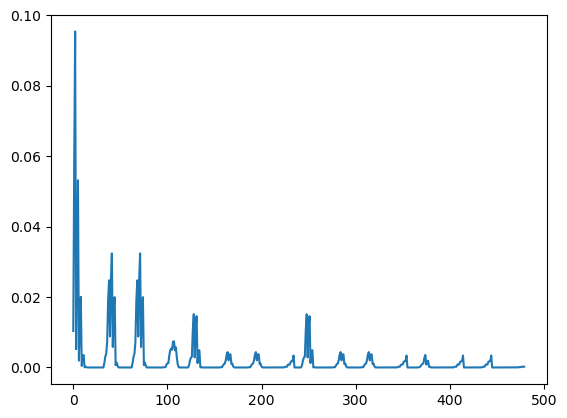

In [10]:
plt.plot(policy_stoch[10])